In [1]:
try:
    import mlagents
    from mlagents_envs.environment import UnityEnvironment as UE
    from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
    print("ml-agents already installed")
except ImportError:
#     !pip install mlagents==0.26.0
    print("Installed ml-agents")

ml-agents already installed


In [2]:
import torch
from typing import Tuple
from math import floor


class VisualQNetwork(torch.nn.Module):
  def __init__(
    self,
    input_shape: Tuple[int], 
    encoding_size: int, 
    output_size: int
  ):
    """
    Creates a neural network that takes as input a batch of images (3
    dimensional tensors) and outputs a batch of outputs (1 dimensional
    tensors)
    """
    super(VisualQNetwork, self).__init__()
#     height = input_shape[0]
#     width = input_shape[1]
#     initial_channels = input_shape[2]
#     conv_1_hw = self.conv_output_shape((height, width), 8, 4)
#     conv_2_hw = self.conv_output_shape(conv_1_hw, 4, 2)
#     self.final_flat = conv_2_hw[0] * conv_2_hw[1] * 32
    
    
#     self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
#     self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
#     self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)

    
    self.dense1 = torch.nn.Linear(input_shape[0], encoding_size)
    self.dense2 = torch.nn.Linear(encoding_size, encoding_size)
    
    self.dense2_x1 = torch.nn.Linear(encoding_size, output_size)
    self.dense2_x2 = torch.nn.Linear(encoding_size, output_size)
    self.dense2_x3 = torch.nn.Linear(encoding_size, output_size)

    
    
  def forward(self, visual_obs: torch.tensor):
#     print("torch input size:", visual_obs.size())
#     visual_obs = visual_obs.permute(0, 3, 1, 2)
#     conv_1 = torch.relu(self.conv1(visual_obs))
#     conv_2 = torch.relu(self.conv2(conv_1))
#     hidden = self.dense1(conv_2.reshape([-1, self.final_flat]))

    hidden = self.dense1(visual_obs)
    hidden = torch.relu(hidden)

    hidden = self.dense2(hidden)
    hidden = torch.relu(hidden)

    x1 = self.dense2_x1(hidden)
    x1 = torch.relu(x1)
    x2 = self.dense2_x2(hidden)
    x2 = torch.relu(x2)
    x3 = self.dense2_x3(hidden)
    x3 = torch.relu(x3)

    return x1, x2, x3

  @staticmethod
  def conv_output_shape(
    h_w: Tuple[int, int],
    kernel_size: int = 1,
    stride: int = 1,
    pad: int = 0,
    dilation: int = 1,
  ):
    """
    Computes the height and width of the output of a convolution layer.
    """
    h = floor(
      ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    w = floor(
      ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    return h, w


In [3]:
import numpy as np
from typing import NamedTuple, List


class Experience(NamedTuple):
  """
  An experience contains the data of one Agent transition.
  - Observation
  - Action
  - Reward
  - Done flag
  - Next Observation
  """

  obs: np.ndarray
  action: np.ndarray
  reward: float
  done: bool
  next_obs: np.ndarray

# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience]

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = List[Experience]

In [6]:
from mlagents_envs.environment import ActionTuple, BaseEnv
from typing import Dict
import random


class Trainer:
  @staticmethod
  def generate_trajectories(
    env: BaseEnv, q_net: VisualQNetwork, buffer_size: int, epsilon: float
  ):
    """
    Given a Unity Environment and a Q-Network, this method will generate a
    buffer of Experiences obtained by running the Environment with the Policy
    derived from the Q-Network.
    :param BaseEnv: The UnityEnvironment used.
    :param q_net: The Q-Network used to collect the data.
    :param buffer_size: The minimum size of the buffer this method will return.
    :param epsilon: Will add a random normal variable with standard deviation.
    epsilon to the value heads of the Q-Network to encourage exploration.
    :returns: a Tuple containing the created buffer and the average cumulative
    the Agents obtained.
    """
    # Create an empty Buffer
    buffer: Buffer = []

    # Reset the environment
    env.reset()
    # Read and store the Behavior Name of the Environment
    behavior_name = list(env.behavior_specs)[0]
    # Read and store the Behavior Specs of the Environment
    spec = env.behavior_specs[behavior_name]

    # Create a Mapping from AgentId to Trajectories. This will help us create
    # trajectories for each Agents
    dict_trajectories_from_agent: Dict[int, Trajectory] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_action_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to cumulative reward (Only for reporting)
    dict_cumulative_reward_from_agent: Dict[int, float] = {}
    # Create a list to store the cumulative rewards obtained so far
    cumulative_rewards: List[float] = []
    
    
    entered_terminal = False
    while len(buffer) < buffer_size:  # While not enough data in the buffer
      # Get the Decision Steps and Terminal Steps of the Agents
      decision_steps, terminal_steps = env.get_steps(behavior_name)
    
        # For all Agents with a Terminal Step:
      for agent_id_terminated in terminal_steps:
#         print("entered agent with terminal step")
#         print(agent_id_terminated)

        # Create its last experience (is last because the Agent terminated)
        last_experience = Experience(
          obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
          reward=terminal_steps[agent_id_terminated].reward,
          done=not terminal_steps[agent_id_terminated].interrupted,
          action=dict_last_action_from_agent[agent_id_terminated].copy(),
          next_obs=terminal_steps[agent_id_terminated].obs[0],
        )
        # Clear its last observation and action (Since the trajectory is over)
        dict_last_obs_from_agent.pop(agent_id_terminated)
        dict_last_action_from_agent.pop(agent_id_terminated)
        # Report the cumulative reward
        cumulative_reward = (
          dict_cumulative_reward_from_agent.pop(agent_id_terminated)
          + terminal_steps[agent_id_terminated].reward
        )
#         print("cumulative reward: ", cumulative_reward)
        cumulative_rewards.append(cumulative_reward) #  - 50
        # Add the Trajectory and the last experience to the buffer
        buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
        buffer.append(last_experience)
        entered_terminal = True

      # For all Agents with a Decision Step:
      for agent_id_decisions in decision_steps:
        # If the Agent does not have a Trajectory, create an empty one
        if agent_id_decisions not in dict_trajectories_from_agent:
          dict_trajectories_from_agent[agent_id_decisions] = []
          dict_cumulative_reward_from_agent[agent_id_decisions] = 0

        # If the Agent requesting a decision has a "last observation"
        if agent_id_decisions in dict_last_obs_from_agent:
          # Create an Experience from the last observation and the Decision Step
          exp = Experience(
            obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
            reward=decision_steps[agent_id_decisions].reward, #  - 0.05
            done=False,
            action=dict_last_action_from_agent[agent_id_decisions].copy(),
            next_obs=decision_steps[agent_id_decisions].obs[0],
          )
          # Update the Trajectory of the Agent and its cumulative reward
          dict_trajectories_from_agent[agent_id_decisions].append(exp)
          dict_cumulative_reward_from_agent[agent_id_decisions] += (
            decision_steps[agent_id_decisions].reward
          )
        # Store the observation as the new "last observation"
        dict_last_obs_from_agent[agent_id_decisions] = (
          decision_steps[agent_id_decisions].obs[0]
        )

      # Generate an action for all the Agents that requested a decision
      # Compute the values for each action given the observation    
      act1, act2, act3 = q_net(torch.from_numpy(decision_steps.obs[0]))
    
      if len(decision_steps) == 0:
#             print("error: no more observations ! ")
            env.step()
            continue
#       if act1.size == 0:
#             print("error: Action space received = 0")
    #         actions_values = np.zeros((3,3))

#             env.step()
#             continue
            
      # get actions as arrays
      act1 = act1.detach().numpy()
      act2 = act2.detach().numpy()
      act3 = act3.detach().numpy()
    
#       print("action received from QNetwork: ", act1)
#       print("action received from QNetwork: ", act2)
#       print("action received from QNetwork: ", act3)
      
      # pick the best action using argmax
      act1 = np.argmax(act1, axis=1)
      act2 = np.argmax(act2, axis=1)
      act3 = np.argmax(act3, axis=1)
      act1 = np.expand_dims(act1, axis=1)
      act2 = np.expand_dims(act2, axis=1)
      act3 = np.expand_dims(act3, axis=1)
      # map action index 2 to -1 for the agent to move backwards, left, and rotate left
      act1[act1 > 1] = -1
      act2[act2 > 1] = -1
      act3[act3 > 1] = -1

      temp = np.hstack((act1, act2, act3))
      actions = temp
      actions.resize((len(decision_steps), 3))


      # Store the action that was picked, it will be put in the trajectory later
      for agent_index, agent_id in enumerate(decision_steps.agent_id):
        dict_last_action_from_agent[agent_id] = actions[agent_index]
#       print("dict last action: ", dict_last_action_from_agent)

        
      # Set the actions in the environment
      # Unity Environments expect ActionTuple instances.
      action_tuple = ActionTuple()
      action_tuple.add_discrete(actions)
#       print("filtered action received from QNetwork: ", action_tuple.discrete)
      env.set_actions(behavior_name, action_tuple)
      # Perform a step in the simulation
      env.step()
    return buffer, np.mean(cumulative_rewards)

  @staticmethod
  def update_q_net(
    q_net: VisualQNetwork, 
    optimizer: torch.optim, 
    buffer: Buffer, 
    action_size: int
  ):
    """
    Performs an update of the Q-Network using the provided optimizer and buffer
    """
    def calculate_bellman_loss(next_pred_action, pred_action, reward, done, GAMMA, batch, action_size, action):
        # Use the Bellman equation to update the Q-Network
        target = (
          reward
          + (1.0 - done)
          * GAMMA
          * torch.max(next_pred_action.detach(), dim=1, keepdim=True).values
        ).double()
#         print("next_act_prediction:", next_pred_action.detach().numpy())
        
#         print("Target:", target)
#         print("Target shape:", target.shape)

#         print("action:", action)
#         print("action shape: ", action.shape)
        assert(action.shape[0] == len(batch))
        action[action < 0] = 2
#         print("action after correction:", action)
        
        mask = np.eye(action_size)[action]
#         mask = torch.zeros((len(batch), action_size))  
#         print("mask: ", mask)
#         print("mask shape: ", mask.shape)
#         mask.scatter_(1, action, 1)
#         print("mask after scatter: ", mask)
        mask = torch.from_numpy(mask).double()
#         print("pred_action: error", pred_action)
#         print(type(pred_action))
#         print(pred_action.dtype)
#         print(type(mask))
#         print(mask.dtype)
        prediction = torch.sum(pred_action.double() * mask, dim=1, keepdim=True)
#         print("act_prediction:", pred_action.detach().numpy())
#         print("prediction: ", prediction)
#         print("prediction shaPE: ", prediction.shape)
#         print("prediction type: ", type(prediction))
#         print("prediction dtype: ", prediction.dtype)
        
        criterion = torch.nn.MSELoss()
        loss = criterion(prediction, target)
        
        return loss

    BATCH_SIZE = 1000
    NUM_EPOCH = 3
    GAMMA = 0.9
    batch_size = min(len(buffer), BATCH_SIZE)
    random.shuffle(buffer)
    # Split the buffer into batches
    batches = [
      buffer[batch_size * start : batch_size * (start + 1)]
      for start in range(int(len(buffer) / batch_size))
    ]
    for _ in range(NUM_EPOCH):
      for batch in batches:
        # Create the Tensors that will be fed in the network
        obs = torch.from_numpy(np.stack([ex.obs for ex in batch]))
        reward = torch.from_numpy(
          np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        done = torch.from_numpy(
          np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        action = torch.from_numpy(np.stack([ex.action for ex in batch]))
        next_obs = torch.from_numpy(np.stack([ex.next_obs for ex in batch]))
        
        # Prerequisite: collect outputs
        pnext_a1, pnext_a2, pnext_a3 = q_net(next_obs)
        p_a1, p_a2, p_a3 = q_net(obs)
        
        # bellman equation for each loss
        loss1 = calculate_bellman_loss(pnext_a1, p_a1, reward, done, GAMMA, batch, action_size, action[:, 0])
        loss2 = calculate_bellman_loss(pnext_a2, p_a2, reward, done, GAMMA, batch, action_size, action[:, 1])
        loss3 = calculate_bellman_loss(pnext_a3, p_a3, reward, done, GAMMA, batch, action_size, action[:, 2])
        loss = loss1 + loss2 + loss3
        
        # Perform the backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [7]:

# Create a new Q-Network. 
qnet = VisualQNetwork((44, 1), 126, 3)




In [9]:
# -----------------
# This code is used to close an env that might not have been closed before
try:
  env.close()
except:
  pass
# -----------------

from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

# Create the GridWorld Environment from the registry
env = UE(file_name='run32_training', seed=1, side_channels=[])
# env = default_registry["GridWorld"].make()
print("GridWorld environment created.")

# moved Qnet outside to reuse it

experiences: Buffer = []
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)

cumulative_rewards: List[float] = []

# The number of training steps that will be performed
NUM_TRAINING_STEPS = 1000000# 70
# The number of experiences to collect per training step
NUM_NEW_EXP = 1000
# The maximum size of the Buffer
BUFFER_SIZE = 10000

for n in range(NUM_TRAINING_STEPS):
  new_exp,_ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
  random.shuffle(experiences)
  if len(experiences) > BUFFER_SIZE:
    experiences = experiences[:BUFFER_SIZE]
  experiences.extend(new_exp)
  Trainer.update_q_net(qnet, optim, experiences, 3)
  _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon=0)
  cumulative_rewards.append(rewards)
  print("Training step ", n+1, "\treward ", rewards)
  print()


env.close()

# Show the training graph
plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards)

GridWorld environment created.
Training step  1 	reward  13.69569231569767

Training step  2 	reward  6.163495083649953

Training step  3 	reward  4.471314929425716

Training step  4 	reward  -1.0

Training step  5 	reward  22.843223206698895

Training step  6 	reward  18.239628486335278

Training step  7 	reward  -1.0

Training step  8 	reward  12.623454064130783

Training step  9 	reward  96.38889029622078

Training step  10 	reward  -1.0

Training step  11 	reward  5.722998201847076

Training step  12 	reward  12.604360289871693

Training step  13 	reward  22.63673460483551

Training step  14 	reward  7.255509942770004

Training step  15 	reward  8.798600455125174

Training step  16 	reward  6.715813487768173

Training step  17 	reward  -0.12093669176101685

Training step  18 	reward  5.7463584045569105

Training step  19 	reward  13.733224898576736

Training step  20 	reward  13.442022303740183

Training step  21 	reward  8.642897218465805

Training step  22 	reward  1.249822719229

KeyboardInterrupt: 

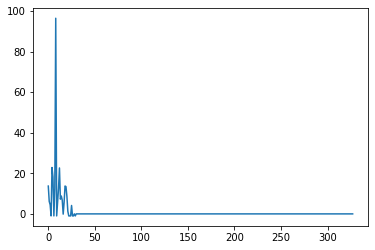

In [11]:
plt.plot(range(328), cumulative_rewards)

In [12]:
env.close()
print("Closed environment")

Closed environment


In [18]:
# pip install --upgrade --user nbconvert
!sudo apt-get install -y texlive-xetex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libauthen-sasl-perl libcommons-logging-java libcommons-parent-java
  libdata-dump-perl libencode-locale-perl libfile-basedir-perl
  libfile-desktopentry-perl libfile-listing-perl libfile-mimeinfo-perl
  libfont-afm-perl libfontbox-java libgs9 libgs9-common libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libijs-0.35 libio-html-perl
  libio-socket-ssl-perl libio-stringy-perl libipc-system-simple-perl
  libjbig2dec0 libjs-jquery libkpathsea6 liblwp-mediatypes-perl
  liblwp-protocol-https-perl libmailtools-perl libnet-dbus-perl
  libnet-http-perl l

In [6]:
!pip install matplotlib

     |████████████████████████████████| 7.2 MB 743 kB/s eta 0:00:01
     |████████████████████████████████| 61 kB 441 kB/s eta 0:00:011
